In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import sparse
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, ShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import pickle
import time
from collections import Counter

In [2]:
# Importing the dataset
traindata = pd.read_csv("data/train.csv")
#testdata = pd.read_csv('data/test.csv')

In [3]:
traindata = traindata.dropna()
print(traindata.shape)

(404287, 6)


In [4]:
labels = np.array(traindata["is_duplicate"])

In [5]:
# Importing the preprocessed dataset
train_preprocessed = pd.read_csv("data/preprocessed_train.csv")
train_preprocessed

,question1_final,question2_final
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government ste...
2,how can i increase the speed of my internet co...,how can internet speed be increase by hack thr...
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water
...,...,...
404282,how many keywords are there in the racket prog...,how many keywords are there in perl program la...
404283,do you believe there is life after death,is it true that there is life after death
404284,what is one coin,what is this coin
404285,what is the approx annual cost of live while s...,i am have little hairfall problem but i want t...


In [6]:
np.isnan(train_preprocessed.any())

question1_final    False
question2_final    False
dtype: bool

In [7]:
vocab = get_vocab_from_all_questions(question1, question2)
print('Extracted {} features from question pairs'.format(len(vocab)))

NameError: name 'get_vocab_from_all_questions' is not defined

## TF-IDF Features based Model

In [7]:
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,3),stop_words='english')
x_1 = vectorizer.fit_transform(train_preprocessed["question1_final"].apply(lambda x : np.str_(x)))
x_2 = vectorizer.fit_transform(train_preprocessed["question2_final"].apply(lambda x : np.str_(x)))

In [8]:
x_1

<404287x1507487 sparse matrix of type '<class 'numpy.float64'>'
	with 4913635 stored elements in Compressed Sparse Row format>

In [9]:
features = hstack([x_1, x_2])

In [10]:
features

<404287x3061018 sparse matrix of type '<class 'numpy.float64'>'
	with 9870566 stored elements in COOrdinate format>

Since the dataset is imbalanced, we did oversample by sampling from the minority class.

In [11]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_data, y_data = oversample.fit_resample(features, labels)

In [12]:
print(np.count_nonzero(y_data == 0))
print(np.count_nonzero(y_data == 1))

255024
255024


In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Models Training
## Support Vector Classifier (SVM Classifier)

In [14]:
splits = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [16]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [17]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [18]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [19]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 80857
max_resources_: 323429
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 80857
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   1.4s
[CV 1/1] END ..........................................C=0.1; total time=   2.8s
[CV 1/1] END ..........................................C=1.0; total time=   6.2s
[CV 1/1] END .........................................C=10.0; total time=  14.3s
[CV 1/1] END ........................................C=100.0; total time=  18.5s
----------
iter: 1
n_candidates: 3
n_resources: 161714
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ..........................................C=0.1; total time=   5.2s
[CV 1/1] END .........................................C=10.0; total time=  55.7s
[CV 1/1] END ..........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000002051A4048B0>,
                    scoring='accuracy', verbose=3)

In [20]:
svc_clf_search.best_params_

{'C': 1.0}

In [21]:
svc_clf_search.best_score_

0.8028816424124995

In [22]:
svc_clf_model = svc_clf_search.best_estimator_

In [23]:
svc_clf_model

LinearSVC(dual=False, max_iter=3000)

In [24]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [25]:
svc_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(dual=False, max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

### Evaluation

Accuracy:  0.8041628533973139
Precision:  0.7971636023948028
Recall:  0.6293242156074015
F1:  0.7033699866998857
ROC AUC:  0.7678526381215779
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     51026
           1       0.80      0.63      0.70     29832

    accuracy                           0.80     80858
   macro avg       0.80      0.77      0.78     80858
weighted avg       0.80      0.80      0.80     80858



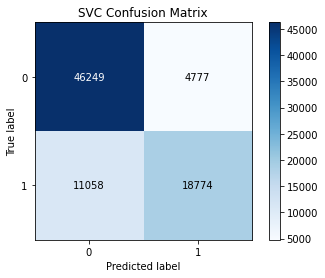

In [26]:
y_pred = svc_calibrated.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/svc_tfidf/svc_confusion_matrix.png')

## Logistic Regression

In [27]:
lr_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [28]:
lr_clf = LogisticRegression(penalty='l2', class_weight='balanced', dual=False, max_iter=3000)

In [29]:
lr_clf_search = HalvingGridSearchCV(lr_clf, lr_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [30]:
lr_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 80857
max_resources_: 323429
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 80857
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   3.8s
[CV 1/1] END ..........................................C=0.1; total time=  13.5s
[CV 1/1] END ..........................................C=1.0; total time=  24.2s
[CV 1/1] END .........................................C=10.0; total time= 1.5min
[CV 1/1] END ........................................C=100.0; total time= 2.9min
----------
iter: 1
n_candidates: 3
n_resources: 161714
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ..........................................C=1.0; total time=  35.2s
[CV 1/1] END ........................................C=100.0; total time= 4.7min
[CV 1/1] END .........................................C

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=3000),
                    factor=2, param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000002051A4048B0>,
                    scoring='accuracy', verbose=3)

In [31]:
lr_clf_search.best_params_

{'C': 10.0}

In [32]:
lr_clf_search.best_score_

0.7973780764315456

In [33]:
lr_clf_model = lr_clf_search.best_estimator_

In [34]:
lr_clf_model

LogisticRegression(C=10.0, class_weight='balanced', max_iter=3000)

### Evaluation

Accuracy:  0.8059684879665586
Precision:  0.762988582691807
Recall:  0.6877178868329311
F1:  0.7234005042224221
ROC AUC:  0.7814103877781635
              precision    recall  f1-score   support

           0       0.83      0.88      0.85     51026
           1       0.76      0.69      0.72     29832

    accuracy                           0.81     80858
   macro avg       0.80      0.78      0.79     80858
weighted avg       0.80      0.81      0.80     80858



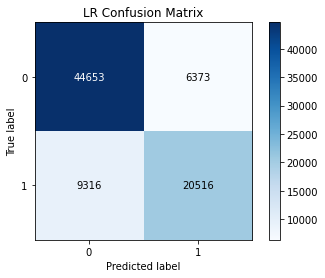

In [35]:
y_pred = lr_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('LR Confusion Matrix')
plt.savefig('graphs/lr_tfidf/lr_confusion_matrix.png')

## Random Forest Classifier

In [15]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [16]:
rf_clf = RandomForestClassifier()

In [17]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [ ]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20214
max_resources_: 323429
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 20214
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200; total time= 3.8min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500; total time= 9.6min
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800; total time=15.5min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200; total time= 1.7min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500; total time= 4.4min
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800; total time= 7.1min
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=200; total time= 9.3min
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=500; total time=22.9min
[CV 1/1] END max_depth=150, min_samples_split=5,

In [ ]:
rf_clf_search.best_params_

In [ ]:
rf_clf_search.best_score_

In [ ]:
rf_clf_model = rf_clf_search.best_estimator_

In [ ]:
rf_clf_model

### Evaluation

In [ ]:
y_pred = rf_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('RF Confusion Matrix')
plt.savefig('graphs/rf_tfidf/rf_confusion_matrix.png')

## XGBoost 

In [15]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

In [16]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_test)

    logloss = log_loss(y_test, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }

In [17]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [18]:
trials = Trials()
best_param = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 5,
            trials = trials)

  0%|                                                                            | 0/5 [00:00<?, ?trial/s, best loss=?]

job exception: bad allocation



  0%|                                                                            | 0/5 [02:27<?, ?trial/s, best loss=?]


XGBoostError: bad allocation

In [ ]:
print("Best Param : ", best_param)

### Training the model with the tuned parameters.

In [ ]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 5,
            eta = 0.33
        )

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
xgb_model = xgb.train(params, dtrain, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

In [ ]:
xgb_clf = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = '5',
                    learning_rate = '0.33',
                )
    
xgb_clf.fit(X_train, y_train)

### Evaluation

In [ ]:
y_predicted_probs = xgb_clf.predict_proba(X_test)

y_pred = xgb_clf.predict(X_test)

print("Log Loss: ", log_loss(y_test, y_predicted_probs))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('XGB Confusion Matrix')
plt.savefig('graphs/xgb_tfidf/xgb_confusion_matrix.png')